In [1]:
%run dataset_preprocessing.ipynb

import argparse
import os
import numpy as np
import math
import sys
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F   # NOTE: I don't think this is used
import torch.autograd as autograd
import torch

from matplotlib import pyplot as plt
from IPython import display


print(torch.cuda.is_available())

False


In [5]:
class opt():   # Class used for optimizers in the future. Defines all variables and stuff needed.
    save_weights = False
    n_epochs = 20000   # an epoch is the number of times it works through the entire training set
    batch_size = 5000   # the training set is broken up into batches, 
                        # and the average loss is used from a given batch for back propagation
    lr = 0.001   # learning rate (how much to change based on error)
    b1 = 0.9   # Used for Adam. Exponential decay rate for the first moment
    b2 = 0.999   # Used for Adam. Exponential decay rate for the second moment estimates (gradient squared)
    input_size = 80
    data_file = "/data"
    config_dir = "."
    save_location = config_dir + data_file
    root_path = "/depot-new/cms/top/mcnama20/TopSpinCorr-Run2-Entanglement/CMSSW_10_2_22/src/TopAnalysis/Configuration/analysis/diLeptonic/three_files"
    file = root_path + "/ee_modified_root_1.root"

    #n_cpu = 2    not used rn

# os.makedirs(config_dir, exit_ok=True)

cuda = True if torch.cuda.is_available() else False


class Classifier(nn.Module):
    """
    classifier layers
    """
    def __init__(self):
        super(Classifier, self).__init__()   # Just uses the module constructor with name Discriminator 

        self.model = nn.Sequential(
            nn.Linear(opt.input_size, 256),   # first layer
            nn.LeakyReLU(0.2, inplace=True),   # apply leaky relu to layer
            nn.Linear(256, 3),   # last layer
            nn.LeakyReLU(0.2, inplace=True)   # apply leaky relu
        )

    def forward(self, input):
        """
        applies model to input and attempts to classify
        """
        output = self.model(input)   # Classifies the input (at location) as gg (0) qqbar (1) or other (2)
        return output


# ******* OUT OF CLASSES NOW ************

# Initialize generator and discriminator
classifier = Classifier()

if cuda:
    classifier.cuda()

    

# # Configure data loader - CHANGE
os.makedirs("./data/", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    ProductionModeDataset(opt.file),
    batch_size=opt.batch_size,
    shuffle=True,
)
print('done')

['ttBar_treeVariables_step8;4;1']
['lb_delta_eta', 'lbbar_delta_eta', 'lnu_delta_eta', 'lnubar_delta_eta', 'lbarb_delta_eta', 'lbarbbar_delta_eta', 'lbarnu_delta_eta', 'lbarnubar_delta_eta', 'bnu_delta_eta', 'bnubar_delta_eta', 'bbarnu_delta_eta', 'bbarnubar_delta_eta', 'lb_delta_phi', 'lbbar_delta_phi', 'lnu_delta_phi', 'lnubar_delta_phi', 'lbarb_delta_phi', 'lbarbbar_delta_phi', 'lbarnu_delta_phi', 'lbarnubar_delta_phi', 'bnu_delta_phi', 'bnubar_delta_phi', 'bbarnu_delta_phi', 'bbarnubar_delta_phi', 'wplusb_delta_eta', 'wplusbbar_delta_eta', 'wminusb_delta_eta', 'wminusbbar_delta_eta', 'wplusb_delta_phi', 'wplusbbar_delta_phi', 'wminusb_delta_phi', 'wminusbbar_delta_phi', 'top_eta', 'top_boosted_eta', 'tbar_eta', 'tbar_boosted_eta', 'ttbar_delta_eta', 'ttbar_eta', 'llbar_delta_eta', 'bbbar_delta_eta', 'nunubar_delta_eta', 'top_phi', 'tbar_phi', 'ttbar_phi', 'ttbar_delta_phi', 'llbar_phi', 'llbar_delta_phi', 'bbbar_phi', 'bbbar_delta_phi', 'nunubar_phi', 'nunubar_delta_phi', 'l_eta', 

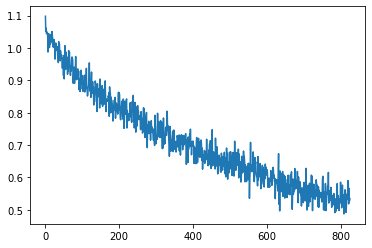

0.58885336
0.5701149


In [ ]:
optimizer = torch.optim.Adam(classifier.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2)) 
# criterion = nn.MSELoss()   # mean squared error loss
criterion = nn.CrossEntropyLoss()

loss_array = np.array(())
batches_done = 0   # Counter for batches
for epoch in range(opt.n_epochs):   # Loop through all epochs
    for i, x in enumerate(dataloader): # x is a batch
                                                # there are i batches in the epoch
        # Configure input
        weight = x[:,81]
        target = x[:,80]
        target = Variable(target.type(torch.LongTensor))
        x = np.transpose(x)
        x = np.delete(x, [80, 81, 82], 0)
        x = np.transpose(x)
#         print("mode " + str(target.shape))
#         print("x " + str(x.shape))
#         print("x" + str(x.type))
        
        # Configure input
        batch = Variable(x.type(torch.Tensor))   # Variable is a wrapper for the Tensor x was just made into

        # ---------------------
        #  Train Classifier
        # ---------------------

        optimizer.zero_grad()   # Make gradients zero so they don't accumulate
        
        # apply nn to input
        output = classifier(batch)

        # Calculate loss 
        loss = criterion(output, target) # -torch.mean(output) + torch.mean(y) # may need to change datatype of y

        loss.backward()   # Do back propagation 
        optimizer.step()   # Update parameters based on gradients for individuals
        batches_done += 1
    
    if epoch % 10 == 0:
        
        #np.save('{file_name}/{num_batches}.npy'.format(file_name=opt.data_file, \
            #num_batches=batches_done), loss)
        
        print(loss.detach().numpy())
        loss_array = np.append(loss_array, loss.detach().numpy())
        
#         line1.set_ydata(loss_array)
#         line1.set_xdata(np.array(list(range(int(epoch/10)+1))))
        if epoch % 50 == 0:
            display.clear_output(True)
            figure = plt.figure()
            ax = figure.add_subplot(111)
            ax.plot(np.array(list(range(int(epoch/10)+1))), loss_array)
#             plt.draw()

            plt.show()

if opt.save_weights:
    torch.save(classifier.model, opt.config_dir + "/singleLayerModel.pt")


